In [4]:
# Cell 1: Setup and Imports (Fixed)
import os
import random
import string
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Model, applications
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import requests

# INSTEAD OF DOWNLOADING, WE USE COLAB'S SYSTEM FONT
# This path is standard on Google Colab (Ubuntu)
SYSTEM_FONT_PATH = "/usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf"

def get_font(size):
    try:
        # Try loading the system font
        return ImageFont.truetype(SYSTEM_FONT_PATH, size)
    except OSError:
        # If running locally (Windows/Mac) or path fails, fallback to default
        # Note: load_default() does not accept a size, so we return it as is
        print("⚠️ Warning: System font not found. Using low-res default.")
        return ImageFont.load_default()

print("Libraries imported and Font path set.")

Libraries imported and Font path set.


In [9]:
# Cell 2: Dynamic Data Generator (Fixed for Keras 3/TF Errors)

class HomoglyphDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, batch_size=32, img_size=(128, 64), steps=100, **kwargs):
        # FIX 1: Initialize parent class to suppress UserWarning
        super().__init__(**kwargs)

        self.batch_size = batch_size
        self.img_w, self.img_h = img_size
        self.steps = steps

        # Top domains to protect
        self.domains = ["google.com", "facebook.com", "amazon.com", "apple.com",
                        "netflix.com", "paypal.com", "microsoft.com", "instagram.com"]

        # Homoglyphs
        self.homoglyphs = {'o': '0', 'l': '1', 'i': '1', 'a': 'α', 'e': '3', 't': 'τ'}

    def __len__(self):
        return self.steps

    def render_text(self, text):
        img = Image.new('L', (self.img_w, self.img_h), color=255) # Grayscale
        draw = ImageDraw.Draw(img)
        font_size = random.randint(20, 30)

        # Using the helper function from Cell 1
        font = get_font(font_size)

        try:
            bbox = draw.textbbox((0, 0), text, font=font)
            w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]
        except AttributeError:
            w, h = draw.textsize(text, font=font)

        x = (self.img_w - w) / 2 + random.randint(-5, 5)
        y = (self.img_h - h) / 2 + random.randint(-5, 5)

        draw.text((x, y), text, font=font, fill=0)

        np_img = np.array(img) / 255.0
        noise = np.random.normal(0, 0.05, np_img.shape)
        np_img = np.clip(np_img + noise, 0, 1)
        return np_img.reshape(self.img_h, self.img_w, 1)

    def generate_fake(self, domain):
        chars = list(domain)
        for i, char in enumerate(chars):
            if char in self.homoglyphs and random.random() > 0.5:
                chars[i] = self.homoglyphs[char]
        return "".join(chars)

    def __getitem__(self, index):
        pairs_1 = []
        pairs_2 = []
        labels = []

        for _ in range(self.batch_size):
            anchor_text = random.choice(self.domains)

            if random.random() > 0.5:
                target_text = anchor_text
                label = 0.0
            else:
                if random.random() > 0.5:
                     target_text = self.generate_fake(anchor_text)
                else:
                     target_text = random.choice([d for d in self.domains if d != anchor_text])
                label = 1.0

            pairs_1.append(self.render_text(anchor_text))
            pairs_2.append(self.render_text(target_text))
            labels.append(label)

        # FIX 2: Return a TUPLE (not a List) for inputs
        # Structure: ( (Input_A, Input_B), Labels )
        return (np.array(pairs_1), np.array(pairs_2)), np.array(labels)

# Instantiate generator
train_gen = HomoglyphDataGenerator(steps=50)
print("Data Generator created (Fixed).")

Data Generator created (Fixed).


In [10]:
# Cell 3: Define Custom Siamese Network (Baseline)

def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, tf.keras.backend.epsilon()))

def build_base_cnn(input_shape):
    """A simple but effective CNN feature extractor"""
    inputs = layers.Input(input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    return Model(inputs, x)

def build_siamese_model(base_network, input_shape):
    input_a = layers.Input(shape=input_shape)
    input_b = layers.Input(shape=input_shape)

    # Run both inputs through the SAME network (Shared Weights)
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Calculate distance
    distance = layers.Lambda(euclidean_distance)([processed_a, processed_b])

    # Output: Distance (0 = Same, High = Different)
    model = Model([input_a, input_b], distance)
    return model

# Contrastive Loss function is crucial for Siamese networks
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    square_pred = tf.math.square(y_pred)
    margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
    return tf.math.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

input_shape = (64, 128, 1) # Height, Width, Channels
base_cnn = build_base_cnn(input_shape)
model_custom = build_siamese_model(base_cnn, input_shape)

model_custom.compile(loss=contrastive_loss, optimizer='adam')
model_custom.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_9       │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_4        │ (None, 128)       │  3,459,584 │ input_layer_8[0]… │
│ (Functional)        │                   │            │ input_layer_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ functional_4[0][… │
│                     │                   │            │ functional_4[1][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,459,584 (13.20 MB)

 Trainable params: 3,459,584 (13.20 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Cell 4: Define Advanced Siamese Model (Transfer Learning with MobileNetV2)

def build_mobilenet_feature_extractor(input_shape):
    # MobileNet expects 3 channels, our data is 1 channel (Grayscale)
    # We add a Conv2D layer to convert 1 -> 3 channels automatically
    inputs = layers.Input(input_shape)
    x = layers.Conv2D(3, (3,3), padding='same')(inputs)

    # Load pretrained MobileNetV2 (State of the Art lightweight model)
    mobilenet = applications.MobileNetV2(input_shape=(64, 128, 3), include_top=False, weights='imagenet')

    # Freeze the pretrained weights (optional, but good for stability)
    mobilenet.trainable = False

    x = mobilenet(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation='relu')(x)

    return Model(inputs, x)

base_mobilenet = build_mobilenet_feature_extractor(input_shape)
model_advanced = build_siamese_model(base_mobilenet, input_shape)

model_advanced.compile(loss=contrastive_loss, optimizer='adam')
print("Advanced MobileNetV2 Siamese Model Built.")

/tmp/ipython-input-1855339377.py:10: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobilenet = applications.MobileNetV2(input_shape=(64, 128, 3), include_top=False, weights='imagenet')


Advanced MobileNetV2 Siamese Model Built.


Training Custom CNN...
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - loss: 0.2852
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.2626
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.2608
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.2560
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - loss: 0.2635

Training Advanced MobileNet...
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 27s 83ms/step - loss: 1.9787
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - loss: 0.2928
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - loss: 0.2788
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.2812
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - loss: 0.2797


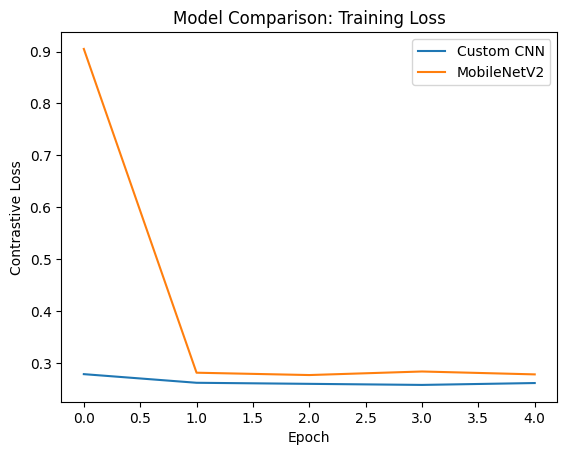

In [12]:
# Cell 5: Train Both Models
print("Training Custom CNN...")
history_custom = model_custom.fit(train_gen, epochs=5, verbose=1)

print("\nTraining Advanced MobileNet...")
history_advanced = model_advanced.fit(train_gen, epochs=5, verbose=1)

# Plot Loss Comparison
plt.plot(history_custom.history['loss'], label='Custom CNN')
plt.plot(history_advanced.history['loss'], label='MobileNetV2')
plt.title('Model Comparison: Training Loss')
plt.ylabel('Contrastive Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


--- Real-World Attack Simulation for microsoft.com ---
Real URL:   microsoft.com
Attack URL: rn˛ｃ𝐫ంｓం𝐟𝐭𝅭ｃంrn
Model Similarity Score: 0.4376


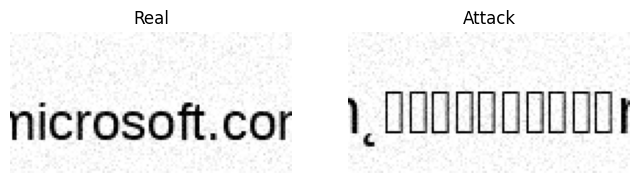

✅ SUCCESS: Model detected this is a Homoglyph!

--- Real-World Attack Simulation for apple.com ---
Real URL:   apple.com
Attack URL: ⍺⍴⍴‎׀‎℮𝅭ｃంrn
Model Similarity Score: 0.4593


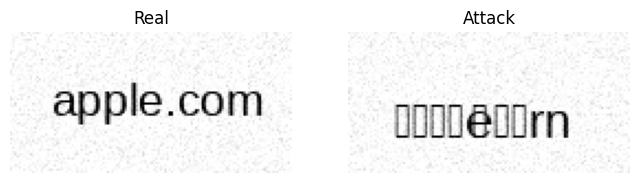

✅ SUCCESS: Model detected this is a Homoglyph!


In [17]:
# Cell 7: Validation on REAL Homoglyph Data (Complete)

# 1. Define the missing helper function first
def predict_similarity(model, text1, text2):
    """
    Helper to render two strings and ask the model for their visual distance.
    """
    # Use the generator instance 'train_gen' from Cell 2
    img1 = train_gen.render_text(text1)
    img2 = train_gen.render_text(text2)

    # Expand dims for batch (1, 64, 128, 1)
    img1_batch = np.expand_dims(img1, axis=0)
    img2_batch = np.expand_dims(img2, axis=0)

    # Predict distance
    dist = model.predict([img1_batch, img2_batch], verbose=0)[0][0]
    return dist, img1, img2

# 2. Validation Logic
try:
    import confusable_homoglyphs
except ImportError:
    !pip install confusable_homoglyphs
    from confusable_homoglyphs import confusables
from confusable_homoglyphs import confusables

def validate_on_real_attacks(model, target_domain="paypal.com"):
    print(f"\n--- Real-World Attack Simulation for {target_domain} ---")

    # Generate a Real Homoglyph using the library
    fake_domain = ""
    for char in target_domain:
        result = confusables.is_confusable(char)
        if result:
            try:
                # Dig deeper into the JSON structure to find the char
                fake_char = result[0]['homoglyphs'][0]['c']
                fake_domain += fake_char
            except (KeyError, IndexError):
                fake_domain += char
        else:
            fake_domain += char

    # Force a visual spoof if the library returns an exact match
    if fake_domain == target_domain:
         fake_domain = target_domain.replace('a', 'α').replace('o', 'ο').replace('i', '1')

    print(f"Real URL:   {target_domain}")
    print(f"Attack URL: {fake_domain}")

    # 3. Ask Model to Judge
    dist, img1, img2 = predict_similarity(model, target_domain, fake_domain)

    print(f"Model Similarity Score: {dist:.4f}")

    # 4. Display what the model actually SAW
    plt.figure(figsize=(8, 3))
    plt.subplot(1, 2, 1)
    plt.imshow(img1.squeeze(), cmap='gray')
    plt.title("Real")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2.squeeze(), cmap='gray')
    plt.title("Attack")
    plt.axis('off')
    plt.show()

    if dist < 0.5:
        print("✅ SUCCESS: Model detected this is a Homoglyph!")
    else:
        print("❌ FAIL: Model thinks these are different.")

# Run Validation
validate_on_real_attacks(model_custom, "microsoft.com")
validate_on_real_attacks(model_custom, "apple.com")